{'11': 362, '00': 72, '10': 171, '01': 395}


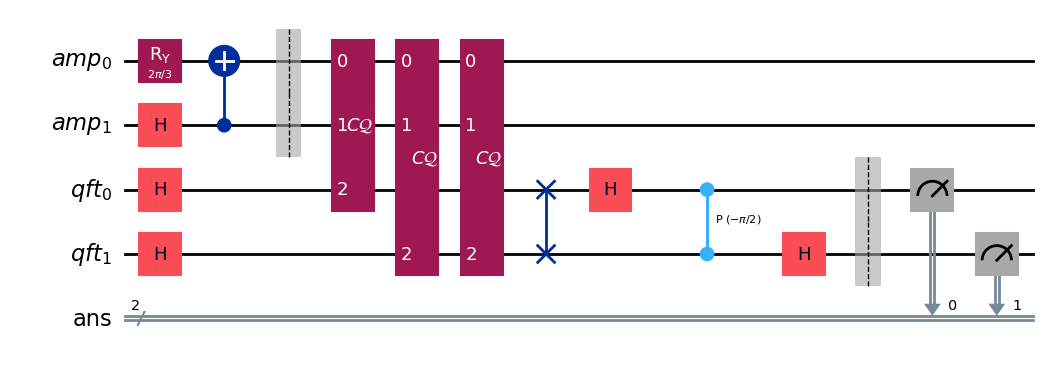

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram
import numpy as np

################
# 説明
################

# 量子振幅推定は、ある量子状態が特定の状態で測定される確率（振幅の2乗）を推定するためのアルゴリズムです。
# 古典的には、あるイベントの確率を推定するには繰り返しサンプリングが必要で、精度 
# 𝜖 を得るには 𝑂(1/(𝜖^2))回の実験が必要です。
# 量子振幅推定では、Grover のアルゴリズムのアイデアを使って、必要な試行回数を 𝑂(1/𝜖) に削減できます。



qr_amp = QuantumRegister(2, name='amp')
qr_qft = QuantumRegister(2, name='qft')
c_ans = ClassicalRegister(2, name='ans')
circuit = QuantumCircuit(qr_amp, qr_qft, c_ans)


################
#### cQ 関数（QAEの心臓部：Groverオラクル相当）
################
def cq(circuit, amp, c):
    qr_cq = QuantumRegister(3)
    circuit_cq = QuantumCircuit(qr_cq, name='$C\\mathcal{Q}$')

    # UΨ_0
    circuit_cq.cx(2, 0)
    circuit_cq.cz(2, 0)
    circuit_cq.cz(2, 1)
    circuit_cq.cx(2, 0)

    # UΨ
    circuit_cq.ccx(2, 1, 0)
    circuit_cq.ch(2, 1)
    circuit_cq.cry(-2 * np.pi / 3, 2, 0)

    circuit_cq.cx(2, 0)
    circuit_cq.cx(2, 1)

    circuit_cq.h(1)
    circuit_cq.ccx(2, 0, 1)
    circuit_cq.h(1)

    circuit_cq.cx(2, 1)
    circuit_cq.cx(2, 0)

    circuit_cq.cry(2 * np.pi / 3, 2, 0)
    circuit_cq.ch(2, 1)
    circuit_cq.ccx(2, 1, 0)

    sub_inst = circuit_cq.to_instruction()
    circuit.append(sub_inst, [amp[0], amp[1], c])
# これは 振幅増幅（Amplitude Amplification） 操作を「制御付き」で行う回路です。
# 通常の QAE では、Grover の演算 
# 𝑄=𝐴𝑆0𝐴†𝑆𝜒 をベースに、位相推定でその位相から振幅を推定します。
# この関数はその代わりに、
# 𝑄 のような作用を再現しようとしており、複雑な論理ゲート（ccx, cry, ch など）を組み合わせてオラクルっぽい処理を作っています。
# 注意点
#ここでの 𝑄 の作り方はハードコードされている（例えば cry(-2π/3) など）、ので一般的な QAE に比べると少し特殊用途です。おそらく何か特定の問題設定に基づいています。


    

# 初期状態 A
circuit.ry(2 * np.pi / 3, qr_amp[0])
circuit.h(qr_amp[1])
circuit.cx(qr_amp[1], qr_amp[0])
# これは、量子状態 𝐴∣0⟩ を準備する部分です。
# RY ゲートで重ね合わせを作り、制御NOTでエンタングルメント（相関）も入れてます。
# ここで作られた状態が、振幅推定対象になります。


circuit.barrier(qr_amp)

################
#### 量子位相推定（QPE）風の構造
################
# 初期化
circuit.h(qr_qft)

# 振幅増幅
cq(circuit, qr_amp, qr_qft[0])

for i in range(2):
    cq(circuit, qr_amp, qr_qft[1])

# ここは QPE における「制御 U^2^j」操作に対応する部分です。
# 量子ビット qr_qft[0] に対して 1 回
# qr_qft[1] に対して 2 回（2 の乗数）

################
#### 逆量子フーリエ変換
################
circuit.swap(qr_qft[0], qr_qft[1])
circuit.h(qr_qft[0])
circuit.cp(-np.pi / 2, qr_qft[0], qr_qft[1])
circuit.h(qr_qft[1])

circuit.barrier(qr_qft)

# 小さなサイズ（2量子ビット）なので、手動で逆QFTしています。これによって振幅に対応する位相が古典レジスタに出力されます。

################
#### 測定
################
circuit.measure(qr_qft, c_ans)

################
#### AerSimulatorを使用したシミュレーション
################
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit, shots=1000).result()

################
#### 結果の取得と表示
################
answer = result.get_counts(circuit)
print(answer)
# plot_histogram(answer)

################
#### 回路図を描画
################
circuit.draw(output='mpl', fold=50)


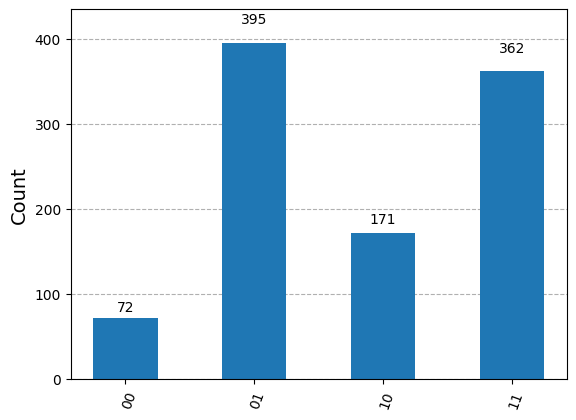

In [2]:
plot_histogram(answer)